In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import os
from tensorflow.keras.optimizers import Adam

In [2]:
# GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(" GPU trouvé:", physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU non trouvé, le processeur sera utilisé.")

 GPU trouvé: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Model loading
MODEL_PATH = 'face_model.h5/face_model.h5'
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [4]:
# Settings
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 32
COLOR_MODE = "grayscale"

DATASET_DIRECTORY, NEW_DIR = "../datasets/facial_emotion_detection_dataset_cropped", "informations_facial_emotion_detection_dataset/"

class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print("Classes:", class_names)

Classes: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [5]:
# Test dataset loading
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    shuffle=False
)

Found 7178 files belonging to 7 classes.


In [6]:
# Get true labels and images
y_true = np.concatenate([labels.numpy() for _, labels in test_ds])
image_batches = np.concatenate([images.numpy() for images, _ in test_ds])

# Predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
confidences = np.max(y_pred_probs, axis=1)


225/225 [==============================] - 6s 6ms/step


In [7]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
classification_rep = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

# Calculate average confidence
average_confidence = np.mean(confidences)


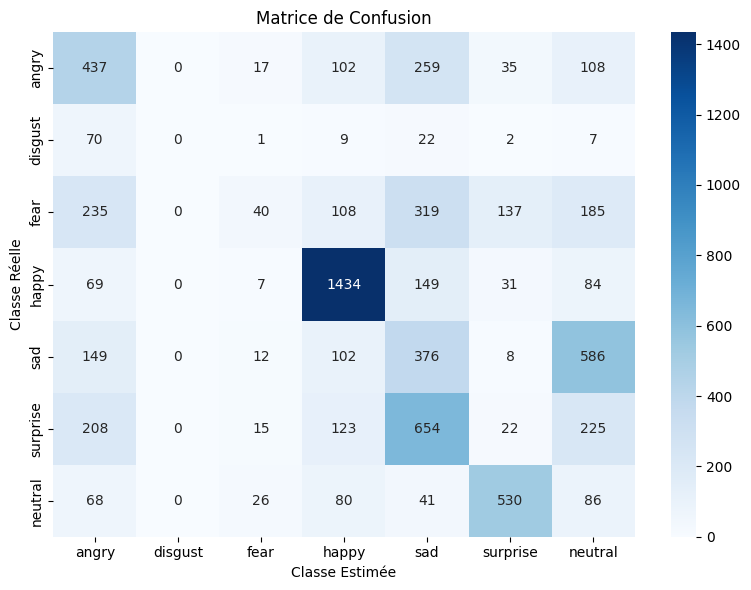

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de Confusion")
plt.xlabel("Classe Estimée")
plt.ylabel("Classe Réelle")
plt.tight_layout()
plt.savefig(NEW_DIR + "confusion_matrix.png")
plt.show()

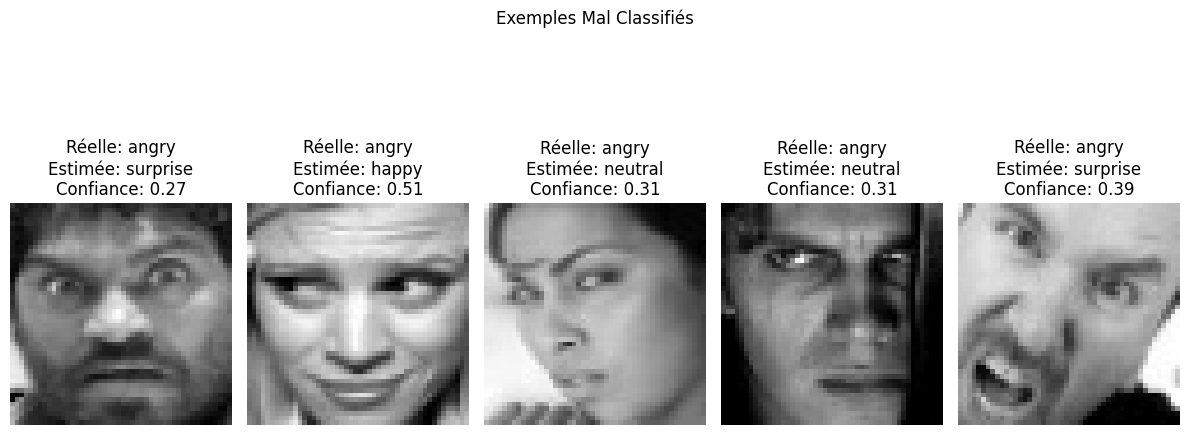

In [9]:
# Incorrectly classified images
incorrect_indices = np.where(y_pred != y_true)[0]
plt.figure(figsize=(12, 6))
for i, idx in enumerate(incorrect_indices[:5]):
    plt.subplot(1, 5, i+1)
    img = image_batches[idx].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"Réelle: {class_names[y_true[idx]]}\nEstimée: {class_names[y_pred[idx]]}\nConfiance: {confidences[idx]:.2f}")
    plt.axis('off')
plt.suptitle("Exemples Mal Classifiés")
plt.tight_layout()
plt.savefig(NEW_DIR + "incorrect_classifications.png")
plt.show()

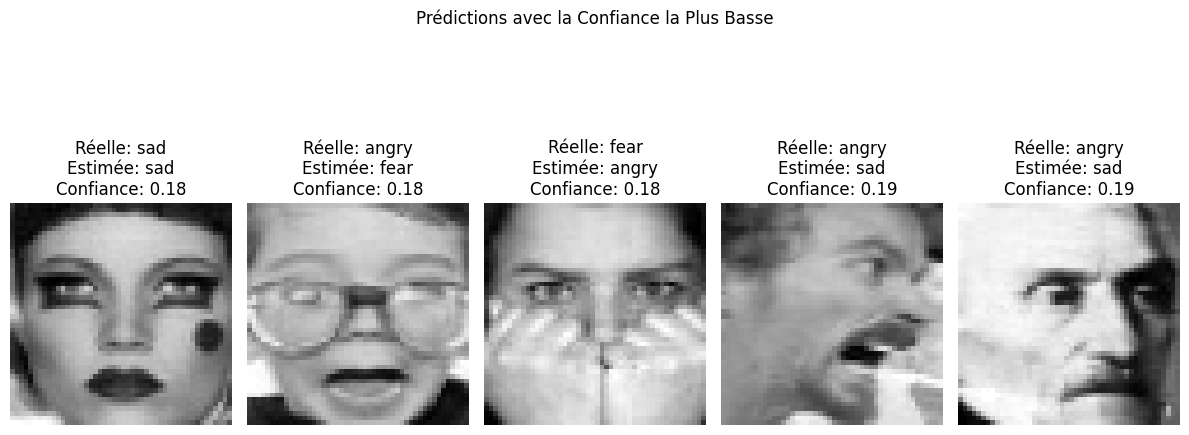

In [10]:
# Low confidence predictions
low_conf_indices = np.argsort(confidences)[:5]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(low_conf_indices):
    plt.subplot(1, 5, i+1)
    img = image_batches[idx].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"Réelle: {class_names[y_true[idx]]}\nEstimée: {class_names[y_pred[idx]]}\nConfiance: {confidences[idx]:.2f}")
    plt.axis('off')
plt.suptitle("Prédictions avec la Confiance la Plus Basse")
plt.tight_layout()
plt.savefig(NEW_DIR + "low_confidence_predictions.png")
plt.show()

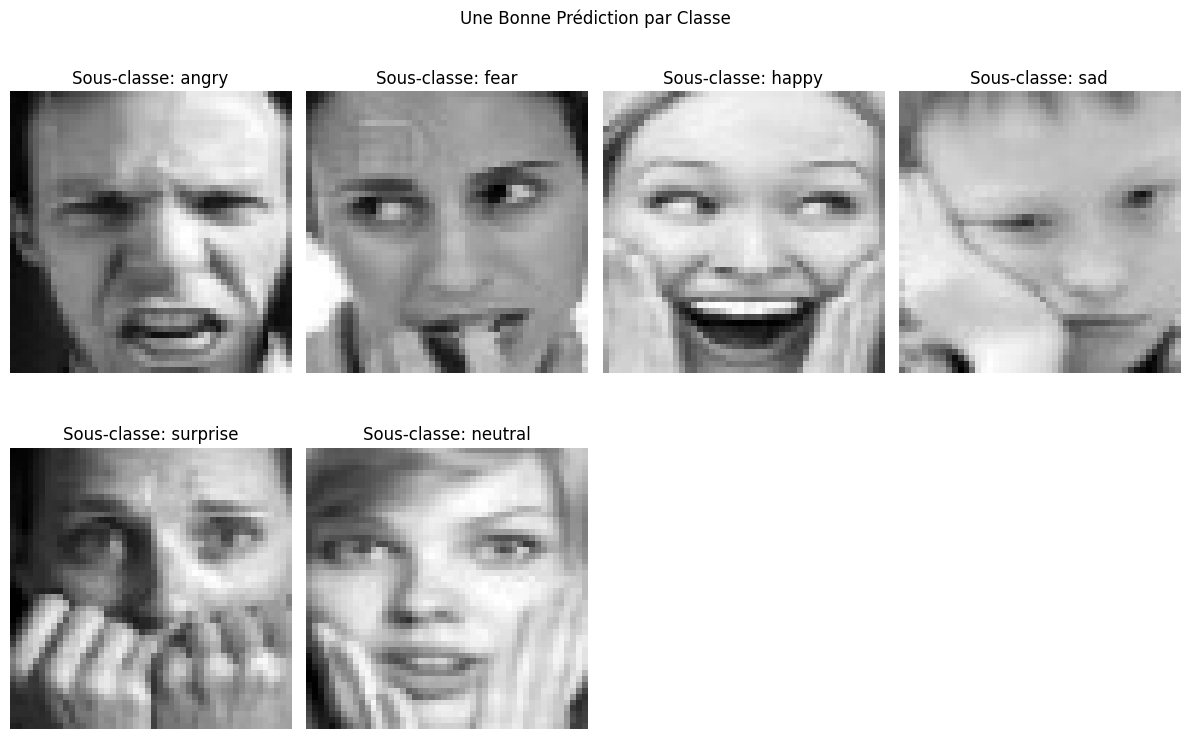

In [11]:
# One correct prediction per class
shown_classes = set()
correct_count = 0
plt.figure(figsize=(12, 8))
for idx in range(len(y_true)):
    if y_true[idx] == y_pred[idx]:
        label = y_true[idx]
        if label not in shown_classes:
            shown_classes.add(label)
            plt.subplot(2, 4, correct_count + 1)
            img = image_batches[idx].squeeze()
            plt.imshow(img, cmap='gray')
            plt.title(f"Sous-classe: {class_names[label]}")
            plt.axis('off')
            correct_count += 1
        if correct_count == len(class_names):
            break
plt.suptitle("Une Bonne Prédiction par Classe")
plt.tight_layout()
plt.savefig(NEW_DIR + "correct_predictions_per_class.png")
plt.show()

In [12]:
# Save scores to a text file
with open(NEW_DIR + "scores.txt", "w") as f:
    f.write(f"Accuracy: {accuracy}\n")
    f.write(f"F1 Score (Macro): {f1}\n")
    f.write("Classification Report:\n")
    f.write(classification_rep)
    f.write(f"\nAverage Confidence: {average_confidence:.4f}\n")
    f.write(f"\nIl y a {len(incorrect_indices)} exemples mal classés.\n") 


In [13]:
print(f"Accuracy: {accuracy}\n")
print(f"F1 Score (Macro): {f1}\n")
print("Classification Report:\n")
print(classification_rep)
print(f"\nAverage Confidence: {average_confidence:.4f}\n")
print(f"\nIl y a {len(incorrect_indices)} exemples mal classés.\n")

Accuracy: 0.33365840066870994

F1 Score (Macro): 0.22664624683598095

Classification Report:

              precision    recall  f1-score   support

       angry       0.35      0.46      0.40       958
     disgust       0.00      0.00      0.00       111
        fear       0.34      0.04      0.07      1024
       happy       0.73      0.81      0.77      1774
         sad       0.21      0.30      0.25      1233
    surprise       0.03      0.02      0.02      1247
     neutral       0.07      0.10      0.08       831

    accuracy                           0.33      7178
   macro avg       0.25      0.25      0.23      7178
weighted avg       0.32      0.33      0.31      7178


Average Confidence: 0.4886


Il y a 4783 exemples mal classés.

